# IREN Competition 2 <a class="anchor" id="top-notebook"></a>

Transfer learning with a convolutional neural network for ship classification.

The project description can be found <a href=http://www.ricou.eu.org/iren/notes_rn.html#Projet%20navires%202021>here</a>.

Members:
* Louis Guo
    * login: louis.guo
* Ilan Guenet
    * login: ilan.guenet
    * <a href=https://github.com/Li0nMo0se>github</a>

## Table of content:
* [Check data](#check-data)
* [Setup data](#setup-data)
* [Data augmentation](#data-augmentation)
* [Model](#model)
* [Model training](#training)
* [Model accuracy](#model-accuracy)
* [Submission](#submission)
* [More images](#more-images)

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import tensorflow.keras
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import os
import skimage
from skimage import io

# Seed
SEED = 2727
np.random.seed(SEED)
tf.random.set_seed(SEED)

%matplotlib inline

# Autocompletion
%config Completer.use_jedi = False

In order to download the data set on kaggle, you are required to download your Kaggle API token from your Kaggle account and store it in your current directory. More details can be found <a href="https://github.com/Kaggle/kaggle-api">here</a>.

In [2]:
# To download the dataset from kaggle
!pip install -q kaggle # Install kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle # Upgrade to the last version

# If you are using pip3 instead of pip
# !pip3 install -q kaggle
# !pip3 install --upgrade --force-reinstall --no-deps kaggle

# /!\ You must store your API token in the current directory
# Move the API token in the ~/.kaggle directory
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the competitions dataset
!kaggle competitions download -c ships2021
!unzip ships2021.zip
!rm ships2021.zip
!ls

Processing /home/li0nmo0se/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106/kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
100%|███████████████████████████████████████▉| 622M/622M [03:22<00:00, 1.64MB/s]
100%|████████████████████████████████████████| 622M/622M [03:22<00:00, 3.22MB/s]
Archive:  ships2021.zip
  inflating: ships2021.tgz           
kaggle.json  main.ipynb  output_model  requirements.txt  ships2021.tgz


In [3]:
# Make the files architecture the same as competition 1
!tar xzf ships2021.tgz
!ls
!mkdir ships_scaled
!mv train ships_scaled/
!rm -r ships2021.tgz
!ls 

kaggle.json  output_model      ships2021.tgz  train
main.ipynb   requirements.txt  test_rot.npy
kaggle.json  output_model      ships_scaled
main.ipynb   requirements.txt  test_rot.npy


In [7]:
# Files architecture
path_train = "ships_scaled/train"
path_test = "ships_scaled/test"
submission_file = "test_rot.npy"

## Check data <a class="anchor" id="check-data"></a>
[Table of content](#top-notebook)

In this part, we are going to get information about the training, test and submission data. We are also going to plot images to see how they look like.
We first write a function that loads data from the train data folder.

In [5]:
def is_rgb_shape(im):
    return len(im.shape) == 3 and im.shape[2] == 3

def get_info_clean_data(path):
    """
    Load data from a directory
    Get info of the data
    Clean the data if necessary
    
    Return:
        * A list of images
        * A list of labels corresponding to the list of images
        * A dataframe describing the images
        * A map of label to class/category name
    """
    curr_label = 0
    label_to_category = dict()

    labels = []
    imgs = []
    info = []

    for dirname in np.sort(os.listdir(path)):
        label_to_category[curr_label] = dirname

        dirname = os.path.join(path, dirname)
        for filename in os.listdir(dirname):
            filename = os.path.join(dirname, filename)

            img = skimage.io.imread(filename)
            # The image is not an rgb image and thus not append
            # The dataset doesn't seem to have such images though
            if not is_rgb_shape(img):
                os.remove(filename)
                continue

            imgs.append(img)
            info.append([filename, curr_label, img.shape[0], img.shape[1], img.dtype])
            labels.append(curr_label)

        curr_label += 1

    labels = np.array(labels)
    df_input = pd.DataFrame(info, columns=["filename", "category", "width", "height", "dtype"])
    return np.array(imgs), labels, df_input, label_to_category

In [ ]:
imgs, labels, df_input, label_to_category = get_info_clean_data(path_train)

In [6]:
print(f"Number of categories: {len(label_to_category)}")
# Warning, label_to_category must be sorted by categories' name in the alphabetical order
label_to_category

Number of categories: 13


{0: 'coastguard',
 1: 'containership',
 2: 'corvette',
 3: 'cruiser',
 4: 'cv',
 5: 'destroyer',
 6: 'ferry',
 7: 'methanier',
 8: 'sailing',
 9: 'smallfish',
 10: 'submarine',
 11: 'tug',
 12: 'vsmallfish'}

The categories of ships are listed below:

|  id | category name  |
|---|---|
| 0  | coastguard |
| 1  | containership |
| 2  | corvette  |
| 3  | cruiser  |
| 4  | cv  |
| 5  | destroyer |
| 6  | ferry  |
| 7  | methanier  |
| 8  | sailing  |
| 9  | smallfish  |
| 10 | submarine  |
| 11 | tug  |
| 12 | vsmallfish  |

Let's show some images now. An image for each category is shown.

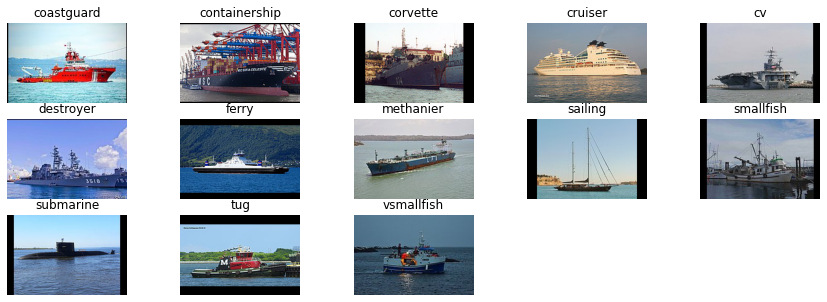

In [7]:
plt.figure(figsize=(15,5))
nb_image_row = 5
for i in range(len(label_to_category)):
    plt.subplot(3, 5, i + 1)
    plt.title(label_to_category[i])
    plt.imshow(imgs[np.argmax(labels==i)])
    plt.axis('off')

plt.show()

We can already notice that images seem to have the same shapes. But let's make sure of it by diving deeper in the metadata of the input.

In [8]:
df_input

,filename,category,width,height,dtype
0,ships_scaled/train/coastguard/2804.jpg,0,128,192,uint8
1,ships_scaled/train/coastguard/2007.jpg,0,128,192,uint8
2,ships_scaled/train/coastguard/1454.jpg,0,128,192,uint8
3,ships_scaled/train/coastguard/452.jpg,0,128,192,uint8
4,ships_scaled/train/coastguard/1484.jpg,0,128,192,uint8
...,...,...,...,...,...
48913,ships_scaled/train/vsmallfish/858.jpg,12,128,192,uint8
48914,ships_scaled/train/vsmallfish/1532.jpg,12,128,192,uint8
48915,ships_scaled/train/vsmallfish/1793.jpg,12,128,192,uint8
48916,ships_scaled/train/vsmallfish/302.jpg,12,128,192,uint8


In [9]:
print(f"How many images with a different width: \
{len(df_input.width[df_input.width != df_input.width[0]])}")

print(f"Every image has the same width which is {df_input.width[0]}")

How many images with a different width: 0
Every image has the same width which is 128


In [10]:
print(f"How many images with a different height: \
{len(df_input.height[df_input.height != df_input.height[0]])}.")

print(f"Every image has the same height which is {df_input.height[0]}.")

How many images with a different height: 0.
Every image has the same height which is 192.


In [11]:
print(f"We can see that every image has the same shape which is {imgs[0].shape}.")

We can see that every image has the same shape which is (128, 192, 3).


For the images, we showed that they all have the same shape. However, some padding (black pixels) was added to the non-(128, 192) images. These black areas should be ignored by the neural network. 

[]

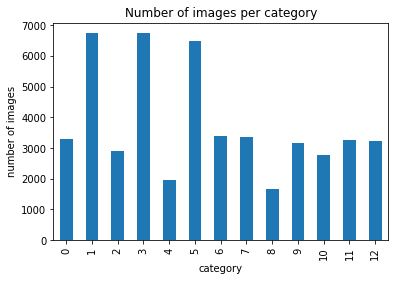

In [12]:
# Plot number of images per category
ax = df_input.category.value_counts(sort=False).plot.bar()
ax.set_xlabel('category')
ax.set_ylabel('number of images')
ax.set_title("Number of images per category")
ax.plot()

Each category has an unbalanced set of images. It is important to know that the neural network will have an unbalanced input. Let's be careful about a category overfitting when training the neural network.

Now, let's see how the submission data looks like

In [13]:
X_submission = np.load(submission_file, allow_pickle=True)
X_submission = X_submission.astype('float32') / 255

target_shape = X_submission.shape[1:3]
X_submission.shape, X_submission.dtype, target_shape

((2315, 128, 192, 3), dtype('float32'), (128, 192))

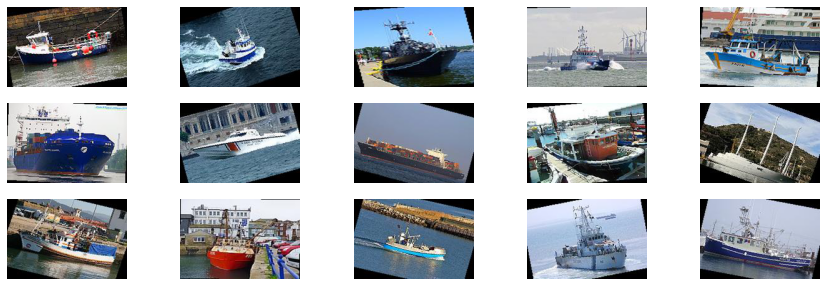

In [14]:
plt.figure(figsize=(15,5))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_submission[i])
    plt.axis('off')
plt.show()

All the submission data has the same shape as the training images which is (128, 192, 3) and the dtype is float32. Extra preprocessing is not required to make the training data complying with the submission data.

In [15]:
# The directory ships_scaled/train already exists and already contains all the images
# Create the ships_scaled/test directory and moved some images
# from train directory to this directory
!mkdir ships_scaled/test

## Setup data <a class="anchor" id="setup-data"></a>
[Table of content](#top-notebook)


We need to split the set of images into three sets:
 * **train set**: data used to train the model (improve the model accuracy).
 * **validation set**: test the model accuracy during the training.
 * **test set**: test the model accuracy after the training.
 
As we are going to use a keras.ImageDataGenerator, it will handle the train set, validation set and test set automatically. However, it is still required to split data into two directories:
* Test data will be located in `ships_scaled/test`. In order to be fair with the test data, we want the same number of images for each category.
* Train/validation data will be located in `ships_scaled/train`.

In [16]:
def setup_data(dir_input, dir_output, label_to_category, nb_test_img_per_category=None):
    """
    Move some images from an input directory to an output directory
    
    Arguments:
        * dir_input: the input directory
        * dir_output: the output directory
        * label_to_category: used to get the category name (thus the directory name)
        * nb_test_img_per_category: number of images per category
    """
    for label, class_name in label_to_category.items():
        class_path = os.path.join(dir_input, class_name)
        new_class_path = os.path.join(dir_output, class_name)
        os.mkdir(new_class_path)
        
        # If None, move everything
        for filename in os.listdir(class_path)[:nb_test_img_per_category]:
            os.rename(os.path.join(class_path, filename),
                      os.path.join(new_class_path, filename))

In [17]:
# Test data will have 100 of images for each category
setup_data(path_train,
           path_test,
           label_to_category,
           nb_test_img_per_category=100)

In [18]:
!ls ships_scaled/test

coastguard     corvette  cv	    ferry      sailing	  submarine  vsmallfish
containership  cruiser	 destroyer  methanier  smallfish  tug


## Data augmentation<a class="anchor" id="data-augmentation"></a>
[Table of content](#top-notebook)


**Data augmentation** is a way to improve the dataset as input images are going to be randomly modified. ImageDataGenerators from keras are going to be used. We are going to have two generators a test ``test_datagen`` and a ``train_datagen``. The last generator is going to have more work as it is going to be used for the training and we want more diversity in the training set. 

Moreover, a pre-trained neural network is going to be used. In this case, input images must all be **preprocessed** by the same and specific preprocess function for resnet neural network ``keras.applications.resnet.preprocess_input``. An automatic way of preprocessing input images is to give this function to a generator.

The generators also **load data on the fly** which, avoid memory issues. Images are saved in directories. Then, the generator will automatically load the image and find its category (from the directory name).

Finally, one of the feature of the generator is to automatically **split training data and validation data**.

To recap, the generators will do the following work:
* preprocess input (always)
* load data on the fly (always)
* data augmentation (if needed)
* split training and validation data (if needed)

### ImageDataGenerator for test set

The test set is here only to test the neural network accuracy. Thus, it is not needed to apply some random modifications to these images meaning data augmentation is not needed. Also, data are not split. The test images will be saved in order to check them after a prediction.

In [19]:
path_gen_test = "gen_test"
!mkdir gen_test

In [20]:
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Categories are sorted by alphabetical order
test_generator = test_datagen.flow_from_directory(
        path_test,
        target_size=target_shape,
        seed=SEED,
        shuffle=False,
        save_to_dir=path_gen_test,
        save_format="jpeg",
        interpolation="bicubic")

Found 1300 images belonging to 13 classes.


### ImageDataGenerator for train/validation set

Besides the preprocessing and load on the fly, the generator for the train/validation data set will have two more tasks.

It will split the dataset into a train set and a validation set. In this notebook, 10% of the images will be exclusively used for validation. On the other hand, 90% of the images will be exclusively used for training.

The generator will also do some data augmentation. Data augmentation is a technique to create new training data (diversifying data) from existing training data by modifying data with imaging operations. The operations are performed randomly in order to get many similar but different images that will likely be seen by the model. This technique often improves neural network accuracy and robustness.

Here, two operations are processed:
* **horizontal flip**: the input image might be flip from left to right. The orientation of the ships should not matter in ship classification. However, a vertical flip is bad because the sea would be located at the top of the image and the ship at the bottom. This situation will never happen in the real world, so this can be omitted.
* **rotation**: the submission images have a rotation of maximum 20 degrees as stated in the project description. In order to get a higher accuracy on the submission images, some random rotations will be ran on the training images. Then, the neural network will be stronger in classifying rotated images. 

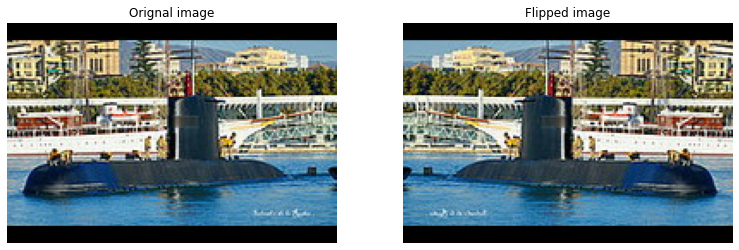

In [21]:
# You can see here a quick example of a horizontal flipped image
from keras.layers.experimental.preprocessing import RandomFlip

np.random.seed(SEED)
rand_img = np.random.randint(len(imgs))

plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plt.imshow(imgs[rand_img])
plt.title("Orignal image")
plt.axis('off')

while True: # Radomly flip until really flip
    # Expand to comply with tensorflow array
    to_flip = np.expand_dims(imgs[rand_img], axis=0)
    to_flip = RandomFlip(mode='horizontal', seed=SEED)(to_flip).numpy()
    # Squeeze to comply with plt.imshow()
    to_flip = np.squeeze(to_flip, axis=0)
    if not np.allclose(to_flip, imgs[rand_img]):
        break
    
plt.subplot(1, 2, 2)
plt.imshow(to_flip)
plt.title("Flipped image")
plt.axis('off')

plt.show()

In [22]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   validation_split=0.1)

# Categories are sorted by alphabetical order
train_generator = train_datagen.flow_from_directory(
        path_train,
        target_size=target_shape,
        batch_size=64,
        seed=SEED,
        subset="training",
        interpolation="bicubic")

# Categories are sorted by alphabetical order
validation_generator = train_datagen.flow_from_directory(
        path_train,
        target_size=target_shape,
        batch_size=64,
        seed=SEED,
        subset="validation",
        interpolation="bicubic")

Found 42863 images belonging to 13 classes.
Found 4755 images belonging to 13 classes.


## Model <a class="anchor" id="model"></a>
[Table of content](#top-notebook)

For this competition, it is required to use a problem solving technique called **transfer learning** (<a href="https://en.wikipedia.org/wiki/Transfer_learning">wiki</a>). It focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. The generic problem is images classification. Our related problem is ship classification.

In this notebook, we are going to use a pre-trained **convolutional neural network** (CNN) model and add on the top of it some custom layers. The transfer of learning comes from the pre-trained CNN model. The knowledge of the pre-trained model will be features maps. Features maps are the output of several consecutive convolutions. Each features map contains an information that will be processed by the outer layers.

Which pre-trained model to use? Three models were considered: 
* <a href="https://keras.io/api/applications/vgg/#vgg16-function">VGG16</a>
* <a href="https://keras.io/api/applications/resnet/#resnet50-function">ResNet50</a>
* <a href="https://keras.io/api/applications/resnet/#resnet50v2-function">ResNet50V2</a>

Every model was fairly tested. However, a problem occurred quickly with the VGG16 model. It takes an hour to process an epoch without data augmentation ! So we changed the pre-trained model and try to use the ResNet50 model. This model is much lighter in terms of computation. As a result, the training time with this model was reasonable and the predictions were quite accurate as it can be seen [below](#training-result). Moreover, a training on the ResNet50V2 model was processed. However, the accuracy on the validation and test data was lower than the ResNet50 accuracy on the same data. To recap, the **ResNet50** is the model used.

Documentation:
* A well-explained documentation of transfer learning can be found of on the keras webiste <a href="https://keras.io/guides/transfer_learning/](https://keras.io/guides/transfer_learning/)">here</a>.
* A exhaustive list of keras avalaible pre-trained models can be found <a href="https://keras.io/api/applications/">here</a>.

### Model creation

Let's now create the model. The model is actually quite simple. It is a sequence of two models. The first model is the ResNet50 model. The loaded model has its weights already computed from a previous training on the <a href="https://imagenet.stanford.edu/">ImageNet</a> dataset. The input shape is the shape of the dataset images. As an output of this model, a **GlobalMaxPooling2D** is applied. It takes the maximum of each features map. The output is flattened by this operation. A GlobalMaxPooling2D seems to be more efficient for the accuracy of the model than a GlobalAveragePooling2D.

On the top of the pre-trained model, a light and custom model is added. This model is a sequential model containing a **BatchNormalization** layer and a **Dense** layer with 13 outputs as the number of categories.

In [23]:
input_shape = (target_shape[0], target_shape[1], 3) # Same shape
input_shape

(128, 192, 3)

In [24]:
from keras.applications import ResNet50

model_resnet50 = ResNet50(include_top=False,
                          weights="imagenet",
                          input_shape=input_shape,
                          pooling='max')

94773248/94765736 [==============================] - 1s 0us/step


In [25]:
print("Nombre de couches : ", len(model_resnet50.layers))

Nombre de couches :  176


In [26]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization

model_custom = Sequential(name='custom_model')
model_custom.add(Input(shape=model_resnet50.output.shape[1:]))
model_custom.add(BatchNormalization(name='custom_bn'))
model_custom.add(Dense(len(label_to_category), activation='softmax'))

In [27]:
print("Nombre de couches : ", len(model_custom.layers))
model_custom.summary()

Nombre de couches :  2
Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_bn (BatchNormalizatio (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 13)                26637     
Total params: 34,829
Trainable params: 30,733
Non-trainable params: 4,096
_________________________________________________________________


In [28]:
from keras.optimizers import Adam

model = Sequential([model_resnet50, model_custom])

print("Nombre de couches : ", len(model.get_layer(name='resnet50').layers) + len(model.get_layer(name='custom_model').layers))
model.summary()

Nombre de couches :  178
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
custom_model (Sequential)    (None, 13)                34829     
Total params: 23,622,541
Trainable params: 23,565,325
Non-trainable params: 57,216
_________________________________________________________________


## Model Training <a class="anchor" id="training"></a>
[Table of content](#top-notebook)


The model is simply **trained** with the training and validation data.

For the **Optimizer**, the Adam optimizer (<a href="https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam">wiki</a>) is going to be used because it seems to be the most efficient.

Two **callbacks** are also used to make the training more convenient. The first callback saves the best weights. Indeed, during the training, the accuracy might vary. Therefore, we want to save the best weights throughout the training. At the end of training, the best weights (with the greatest validation accuracy) are loaded into the model. The second callback stops the training when the validation accuracy has not improved for 5 times in a row. This is useful to not waste training time when it is not needed.

There are two training steps. The **first step** is to only train the layers in the custom on the top model. The ResNet50 layers are frozen. The features maps from ResNet50 already give great information to classify ships. During this step, 70% of validation accuracy is reached. We can also notice a **dense** is actually enough which confirm the efficiency of ResNet50. Then, a second training is performed. This time, the whole model (the ResNet50 model and the custom model) is trainable. During this second step, the learning is very low because it is a step of **fine tuning**. The weights of the ResNet50 model should only be slightly modified.

### Model compilation

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# Freeze the model, we don't want to train again.
model_resnet50.trainable = False
# Freeze the BatchNormalization in the custom model
model_custom.get_layer('custom_bn').trainable = False

print(f"resnet50 model is trainable? {model.get_layer(name='resnet50').trainable}.")
print(f"The custom model is trainable? {model.get_layer(name='custom_model').trainable}.")
print(f"The batch normalization layer is trainable? {model.get_layer(name='custom_model').get_layer('custom_bn').trainable}.")

resnet50 model is trainable? False.
The custom model is trainable? True.
The batch normalization layer is trainable? False.


### Callbacks

In [31]:
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model_checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True,
                                            verbose=1)

In [32]:
from keras.callbacks import EarlyStopping

model_earlystop_callback = EarlyStopping(monitor='val_accuracy',
                                         patience=5,
                                         verbose=1)

### First train

In [33]:
nb_epochs = 10

# Model weights are saved at the end of every epoch, if it is the best seen
# so far.
model_history = model.fit(x=train_generator,
                          epochs=nb_epochs,
                          verbose=1,
                          validation_data=validation_generator,
                          callbacks=[model_checkpoint_callback, model_earlystop_callback])

Epoch 1/10
670/670 [==============================] - 330s 477ms/step - loss: 1.0156 - accuracy: 0.6671 - val_loss: 0.4525 - val_accuracy: 0.8391

Epoch 00001: val_accuracy improved from -inf to 0.83912, saving model to model_checkpoint
Epoch 2/10
670/670 [==============================] - 319s 476ms/step - loss: 0.3189 - accuracy: 0.8847 - val_loss: 0.3789 - val_accuracy: 0.8646

Epoch 00002: val_accuracy improved from 0.83912 to 0.86456, saving model to model_checkpoint
Epoch 3/10
670/670 [==============================] - 322s 481ms/step - loss: 0.2242 - accuracy: 0.9172 - val_loss: 0.3927 - val_accuracy: 0.8688

Epoch 00003: val_accuracy improved from 0.86456 to 0.86877, saving model to model_checkpoint
Epoch 4/10
670/670 [==============================] - 317s 473ms/step - loss: 0.1710 - accuracy: 0.9356 - val_loss: 0.3707 - val_accuracy: 0.8709

Epoch 00004: val_accuracy improved from 0.86877 to 0.87087, saving model to model_checkpoint
Epoch 5/10
670/670 [=======================

### Fine-tuning

In [34]:
# Unfreeze resnet50 layers
model_resnet50.trainable = True
# Unfreeze the BatchNormalization in the custom model
model_custom.get_layer('custom_bn').trainable = True

# Notice the low learning rate.
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
custom_model (Sequential)    (None, 13)                34829     
Total params: 23,622,541
Trainable params: 23,565,325
Non-trainable params: 57,216
_________________________________________________________________


In [35]:
print(f"resnet50 model is trainable? {model.get_layer(name='resnet50').trainable}.")
print(f"The custom model is trainable? {model.get_layer(name='custom_model').trainable}.")
print(f"The batch normalization layer is trainable? {model.get_layer(name='custom_model').get_layer('custom_bn').trainable}.")

resnet50 model is trainable? True.
The custom model is trainable? True.
The batch normalization layer is trainable? True.


In [36]:
nb_epochs_tuning = 20

model_history_tunning = model.fit(x=train_generator,
                                  epochs=nb_epochs_tuning,
                                  verbose=1,
                                  validation_data=validation_generator,
                                  callbacks=[model_checkpoint_callback, model_earlystop_callback])

Epoch 1/20
670/670 [==============================] - 320s 470ms/step - loss: 0.0502 - accuracy: 0.9828 - val_loss: 0.3226 - val_accuracy: 0.8997

Epoch 00001: val_accuracy improved from 0.88433 to 0.89968, saving model to model_checkpoint
Epoch 2/20
670/670 [==============================] - 316s 472ms/step - loss: 0.0210 - accuracy: 0.9940 - val_loss: 0.3298 - val_accuracy: 0.9047

Epoch 00003: val_accuracy did not improve from 0.90578
Epoch 4/20
670/670 [==============================] - 313s 468ms/step - loss: 0.0161 - accuracy: 0.9954 - val_loss: 0.3593 - val_accuracy: 0.9007

Epoch 00004: val_accuracy did not improve from 0.90578
Epoch 5/20
670/670 [==============================] - 314s 468ms/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 0.3480 - val_accuracy: 0.9075

Epoch 00005: val_accuracy improved from 0.90578 to 0.90747, saving model to model_checkpoint
Epoch 6/20
670/670 [==============================] - 316s 471ms/step - loss: 0.0112 - accuracy: 0.9970 - val_loss: 

In [37]:
model_path = "output_model"

In [38]:
from keras.models import load_model
# Instead of training weights can be loaded here
# Load the model
# model = load_model(model_path)
# model.summary()

### Check training results <a id="training-result"></a>

It is now time to see the result of the training steps. History of the training is put in a DataFrame. Then, we plot the **train accuracy** and **validation accuracy** over epochs.

In [39]:
hist_custom_df = pd.DataFrame(model_history.history) 
hist_tuning_df = pd.DataFrame(model_history_tunning.history) 
hist_df = pd.concat([hist_custom_df, hist_tuning_df])
hist_df.head(5)

,loss,accuracy,val_loss,val_accuracy
0,0.656512,0.774188,0.452481,0.839117
1,0.314618,0.885822,0.378886,0.864564
2,0.234083,0.913562,0.392660,0.868770
3,0.178200,0.933906,0.370704,0.870873
4,0.155708,0.941675,0.389186,0.865405


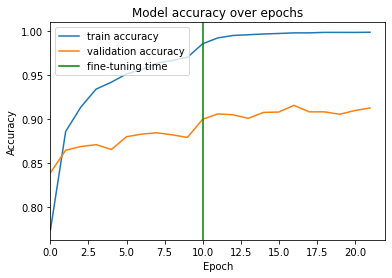

In [40]:
plt.plot(hist_df.accuracy.to_numpy())
plt.plot(hist_df.val_accuracy.to_numpy())
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim([0, hist_df.index.size])
plt.axvline(x=nb_epochs, color='green')
plt.legend(['train accuracy', 'validation accuracy', 'fine-tuning time'], loc='upper left')
plt.show()

We can see that the first training did not really improve the accuracy. The validation accuracy stays around 72% over the 10 first epochs. Thus, it is not needed to only train any longer the custom model. There is a very low training accuracy and slightly lower validation accuracy in between the two trainings for some unknown reasons. It is not very important as the validation accuracy is not that lower and comes back to 72% after an epoch. During the fine-tuning step, the training and validation accuracy keep improving. At the end of the training, the model seems to overfit a bit. But again, it does not really matter because the validation accuracy is high. 

## Model accuracy <a class="anchor" id="model-accuracy"></a>
[Table of content](#top-notebook)

Here is the crucial moment. Let's evaluate the accuracy of the model. The evaluation is performed on the test data only. As a reminder, there is a 100 of images for each category.

First, the **model accuracy** is checked. One evaluation is performed. The evaluated model is the model with the best computed weights.

After this step, the best model is loaded. Then, the **confusion matrix** is plotted. Some interpretations might become possible thanks to this matrix.

Finally, a **classification report** is generated to get a summary of the model classification capabilities.

### Compute accuracy

The **accuracy** computed this way: $$Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} $$ 

In [41]:
# Load the best model
# The model weights (that are considered the best) are loaded into the model.
# DO NOT LOAD if no checkpoint.
model.load_weights(checkpoint_filepath)

In [42]:
metrics = model.evaluate(test_generator)
print("The model accuracy over the test data %.2f%%"%(metrics[1] * 100))

41/41 [==============================] - 5s 126ms/step - loss: 0.2983 - accuracy: 0.9231
The model accuracy over the test data 92.31%


In [43]:
# Save the model
model.save(filepath=model_path)

### Confusion Matrix

A confusion matrix usage is to evaluate the quality of the output of a classifier. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The true labels are represented by the rows and the predictions by the columns.

Documentation:
 * scikit-learn documentation of confusion matrix <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html">here</a>.

In [44]:
import seaborn as sn

def my_plot_confusion_matrix(conf_matrix, classes, title=None):
    df_cm = pd.DataFrame(conf_matrix, classes, classes)
    plt.figure(figsize=(10,5))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, cmap='Oranges', fmt='g', annot=True, annot_kws={"size": 11}) # font size
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title:
        plt.title(title)

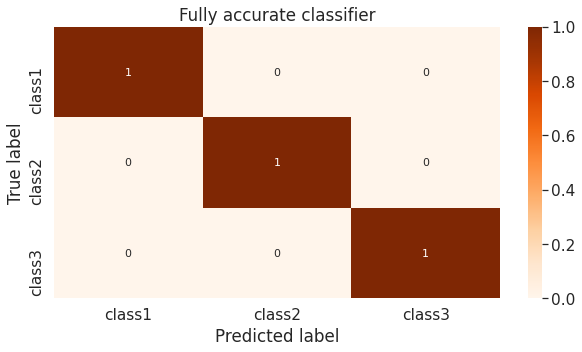

In [45]:
example_classes = ['class1', 'class2', 'class3']
example_val = np.identity(3)
my_plot_confusion_matrix(example_val, example_classes, title="Fully accurate classifier")

In [46]:
from sklearn.metrics import confusion_matrix

# compute the confusion matrix of the model
y_pred = model.predict(test_generator).argmax(axis=1)
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

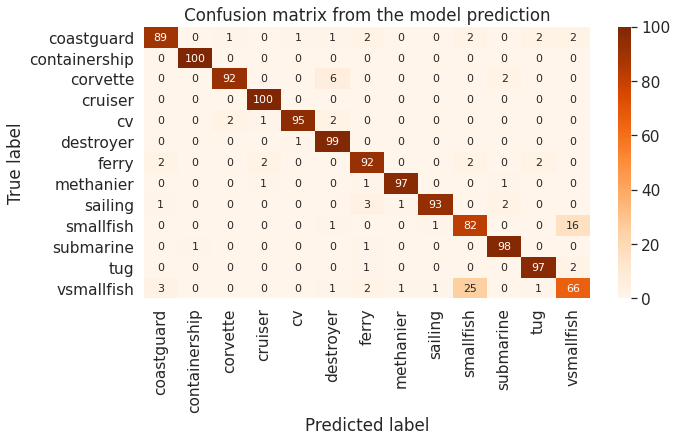

In [47]:
my_plot_confusion_matrix(conf_matrix, label_to_category.values(), title="Confusion matrix from the model prediction")

The confusion matrix looks great. Most of the values are on the diagonal. The model has one main difficulty. It mixes smallfish and vsmallfish up. That is understandable as these two kind of ships look alike.

### Classfication report

As a reminder:

The **precision** for a class is the number of correctly predicted images of this class out of all predicted images of this class.

The **recall** for a class is the number of correctly predicted images of this class out of the number of actual images of this class.

The **f1-score** is the combination of the precision the score and recall score such that $$\text{f1 score} = 2\frac{\text{precision}  \times \text{recall}}{\text{precision} + \text{recall}}$$ It tries to compromise the precision with the recall.

The closer these scores get to 1, the more accurate the model is.

The blue rectangle represents the recall of class1
The green rectangle represents the precision of class1


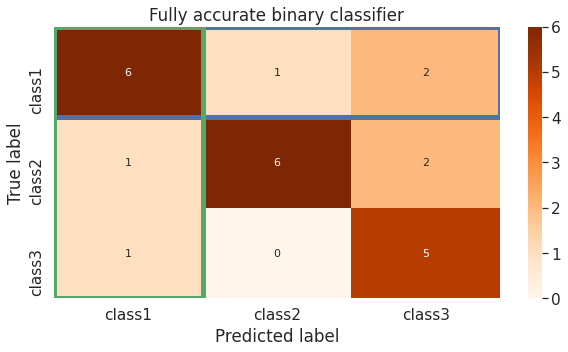

In [48]:
import matplotlib.patches as patches

example_val = np.array([[6, 1, 2], [1, 6, 2], [1, 0, 5]])
my_plot_confusion_matrix(example_val, example_classes, title="Fully accurate binary classifier")
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(patches.Rectangle((0, 0), 3, 1, linewidth=5, edgecolor='b', facecolor='none'))
ax.add_patch(patches.Rectangle((0, 0), 1, 3, linewidth=5, edgecolor='g', facecolor='none'))
print("The blue rectangle represents the recall of class1")
print("The green rectangle represents the precision of class1")

In [49]:
from sklearn.metrics import classification_report

print(classification_report(test_generator.classes, y_pred, target_names=label_to_category.values()))

               precision    recall  f1-score   support

   coastguard       0.94      0.89      0.91       100
containership       0.99      1.00      1.00       100
     corvette       0.97      0.92      0.94       100
      cruiser       0.96      1.00      0.98       100
           cv       0.98      0.95      0.96       100
    destroyer       0.90      0.99      0.94       100
        ferry       0.90      0.92      0.91       100
    methanier       0.98      0.97      0.97       100
      sailing       0.98      0.93      0.95       100
    smallfish       0.74      0.82      0.78       100
    submarine       0.95      0.98      0.97       100
          tug       0.95      0.97      0.96       100
   vsmallfish       0.77      0.66      0.71       100

     accuracy                           0.92      1300
    macro avg       0.92      0.92      0.92      1300
 weighted avg       0.92      0.92      0.92      1300



All the scores are close to 1 besides the vsmallfish and smallfish as it could be seen from the confusion matrix.

### Check generated data

Here, the images generated by the test data generator are quickly checked.

In [50]:
def show_some_images(path_dir, title="images"):
    plt.figure(figsize=(20,8))
    i = 0
    for path_img in os.listdir(path_dir)[:15]:
        img = skimage.io.imread(os.path.join(path_dir, path_img))

        if i == 0:
            print("Shape of the " + title + ": ", img.shape)
            print("Data type of the " + title + ": ", img.dtype)

        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        i += 1

Shape of the Generated test images:  (128, 192, 3)
Data type of the Generated test images:  uint8


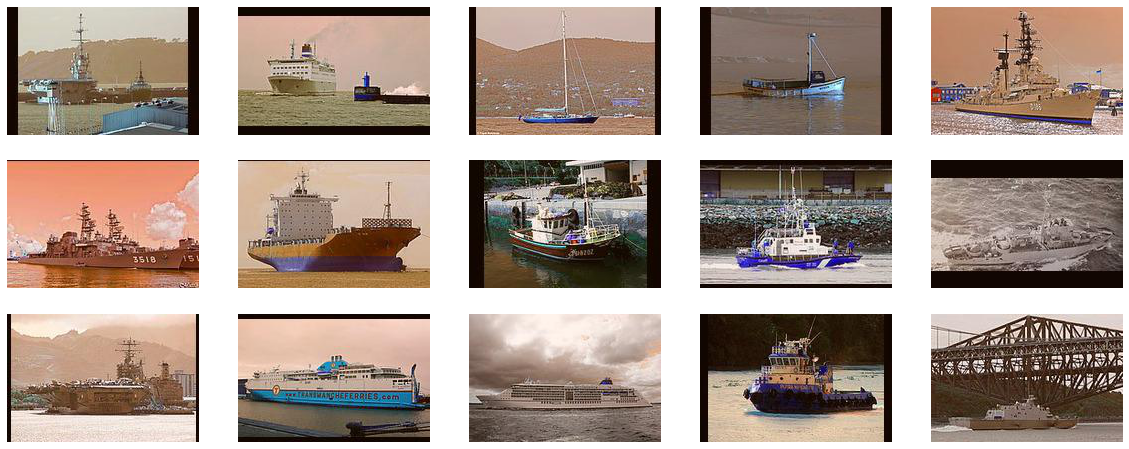

In [51]:
show_some_images(path_gen_test, "Generated test images")

The generated images seem to comply with ResNet50 input.

## Submission <a class="anchor" id="submission"></a>
[Table of content](#top-notebook)

In this part, the submission to the competition is made. The submission images are loaded from the ``test_rot.npy`` file. Then, the model predicts the category of the images. The result is stored in a CSV file. This CSV file is the submission file.

In [52]:
X_submission = np.load(submission_file, allow_pickle=True)
# Do not forget to preprocess input to ResNet50 input format. 
X_submission = preprocess_input(X_submission)
X_submission.shape, X_submission.dtype

((2315, 128, 192, 3), dtype('float32'))

In [53]:
res = model.predict(X_submission).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

In [54]:
!head reco_nav.csv

Id,Category
0,12
1,9
2,2
3,0
4,12
5,1
6,0
7,1
8,12


In [55]:
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv

In [10]:
!rm -rf ships_scaled/
!rm -rf gen_test

## More images <a class="anchor" id="more-images"></a>
[Table of content](#top-notebook)

The model will now be evaluated on images we found ourselves. The dataset can be found <a href="https://www.kaggle.com/ilanguenet/shipsforepita">here</a>. The images were randomly picked no matter the strength and weakness of the model. It is another good way to test the model accuracy.

Before making the prediction, we check the images from the dataset. Then, the same analysis of the result as for the test set (explanations  [here](#model-accuracy)) is performed with:
* The accuracy of the model
* The confusion matrix
* The recall score, the precision score and the f1-score

In [4]:
# Move in working directory
# Download the dataset from kaggle
!kaggle datasets download --unzip ilanguenet/shipsforepita
# Move in working directory
!mkdir more_ships
!cp -r ships/* more_ships
!ls more_ships

100%|█████████████████████████████████████████| 426k/426k [00:02<00:00, 180kB/s]
100%|█████████████████████████████████████████| 426k/426k [00:02<00:00, 180kB/s]
coastguard     corvette  cv	    ferry      sailing	  submarine  vsmallfish
containership  cruiser	 destroyer  methanier  smallfish  tug


In [58]:
# Get information
path_test_bis = "more_ships"
imgs_bis, labels_bis, df_input_bis, label_to_category_bis = get_info_clean_data(path_test_bis)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [59]:
print(f"Number of categories: {len(label_to_category_bis)}")
# Warning, label_to_category must be sorted by categories' name in the alphabetical order
print(f"Same categories as the given dataset? {label_to_category_bis == label_to_category}")
print(f"Number of images: {len(imgs_bis)}.")

Number of categories: 13
Same categories as the given dataset? True
Number of images: 20.


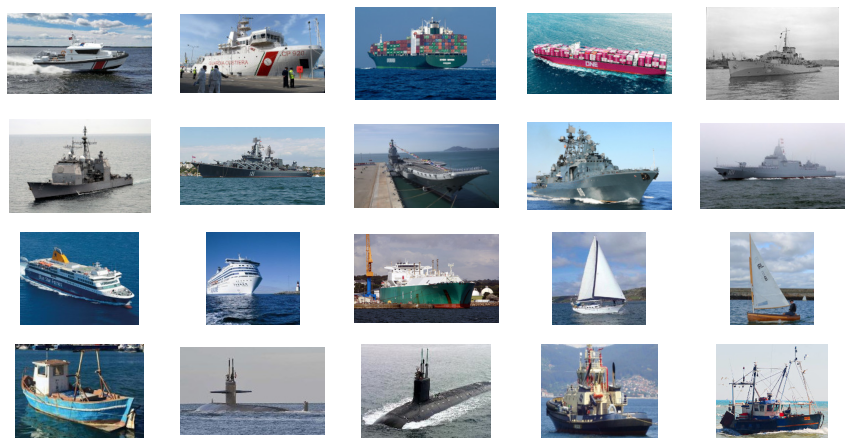

In [60]:
# Let's plot all the images
plt.figure(figsize=(15,10))
for i in range(len(imgs_bis)):
    plt.subplot((len(imgs_bis) // nb_image_row) + 1, nb_image_row, i + 1)
    plt.imshow(imgs_bis[i])
    plt.axis('off')
plt.show()

[]

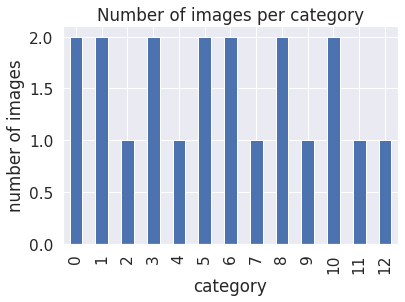

In [61]:
# Plot number of images per category
ax = df_input_bis.category.value_counts(sort=False).plot.bar()
ax.set_xlabel('category')
ax.set_ylabel('number of images')
ax.set_title("Number of images per category")
ax.plot()

In [62]:
# test_datagen preprocess input
test_bis_generator = test_datagen.flow_from_directory(
        path_test_bis,
        target_size=target_shape, # Need resize
        seed=SEED,
        shuffle=False,
        interpolation="bicubic")

Found 20 images belonging to 13 classes.


In [63]:
metrics = model.evaluate(test_bis_generator)
print("The model accuracy over the handmade dataset %.2f%%"%(metrics[1] * 100))

1/1 [==============================] - 0s 107ms/step - loss: 3.0658 - accuracy: 0.7000
The model accuracy over the handmade dataset 70.00%


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

   coastguard       1.00      1.00      1.00         2
containership       1.00      1.00      1.00         2
     corvette       1.00      1.00      1.00         1
      cruiser       0.00      0.00      0.00         2
           cv       0.00      0.00      0.00         1
    destroyer       0.50      1.00      0.67         2
        ferry       0.50      0.50      0.50         2
    methanier       1.00      1.00      1.00         1
      sailing       1.00      1.00      1.00         2
    smallfish       0.50      1.00      0.67         1
    submarine       1.00      1.00      1.00         2
          tug       0.00      0.00      0.00         1
   vsmallfish       0.00      0.00      0.00         1

     accuracy                           0.70        20
    macro avg       0.58      0.65      0.60        20
 weighted avg       0.62      0.70      0.65        20



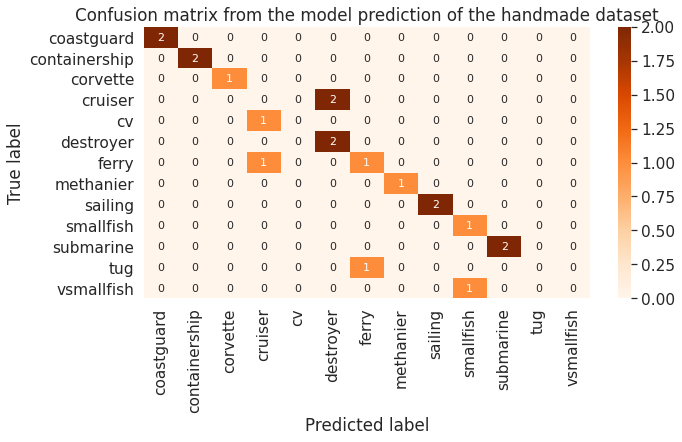

In [64]:
# compute the confusion matrix of the model
y_pred_bis = model.predict(test_bis_generator).argmax(axis=1)
conf_matrix = confusion_matrix(test_bis_generator.classes, y_pred_bis)

# Plot the confusion matrix
my_plot_confusion_matrix(conf_matrix, label_to_category_bis.values(),
                         title="Confusion matrix from the model prediction of the handmade dataset")

# Print the classification report
print(classification_report(test_bis_generator.classes,
                            y_pred_bis,
                            target_names=label_to_category_bis.values()))

In [11]:
!rm -rf more_ships